In [26]:
# free space from GPU device
from numba import cuda
cuda.select_device(0)
cuda.close()

In [1]:
import numpy as np
import importlib
import time
import glob
%matplotlib nbagg
# %matplotlib qt
# %matplotlib
# %matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import scipy
import tensorflow as tf
import hyperspy.api as hs

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="1" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [3]:
from keras import applications, optimizers, callbacks
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [4]:
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData_noFeatureCenter.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData_smallShift.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_WhiteNoise.h5'
# model_path = 'CNNmodels/VGG16_usim_40mradEmit+defocus_noApt.h5'
# model_path = 'CNNmodels/VGG16_nion_30mradEmit+defocus_28mradApt.h5'
# model_path = 'CNNmodels/VGG16_nion_midAbr_30mradEmit_28mradApt_test18-04.h5'
# model_path = 'CNNmodels/VGG16_nion_midAbr_30mradEmit+defocus_28mradApt.h5'
# model_path = '/home/chenyu/Desktop/CNNmeasurement/CoarseCNNtraining/VGG16/OptimalPar_newData/Test18_NionNetwork_VOAin/08_emit_2ndOrder_50mrad_emit_45mradApt/Archive_083021_noFeatureCenter/Final_model.h5'
model_path = '/home/chenyu/Desktop/CNNmeasurement/CoarseCNNtraining/VGG16/OptimalPar_newData/Test18_NionNetwork_VOAin/09_emit+defocus_2ndOrder_50mrad_emit_45mradApt/Archive_090321_dropout0.3/Final_model_2.h5'
# model_path = 'CNNmodels/VGG16_30mrademit+defocus_30mradApt_lowAbr_test12_05.h5' 

In [5]:
model = applications.VGG16(weights=None, include_top=False, input_shape=(128, 128, 3))
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(1,activation=None))
new_model = Sequential()

for l in model.layers:
    new_model.add(l)

new_model.add(top_model)
new_model.load_weights(model_path)

In [6]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [7]:
def scale_range(input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

In [8]:
def scale_range_aperture(input, min, max):
    hist, bin_edges = np.histogram(np.ndarray.flatten(input), bins = 'auto')
    idx = np.argmin(abs(np.gradient(hist)[0:len(hist)//2]))
    threshold = bin_edges[idx]
    input += -threshold
    input[input<0] = 0
    input /= np.max(input) / (max - min)
    input += min
    return input

In [9]:
def scale_range_aperture_2(img, min, max):
    mask = aperture_generator(128, 50, 40)
    array = np.ndarray.flatten(img[np.where(mask==1)])
    img = img - np.amin(array)
    img = img / (np.amax(array) - np.amin(array))
    img = img * (max - min)
    img += min
    return img

In [10]:
abr_list = ["C10", "C12.x", "C12.y", "C21.x", "C21.y", "C23.x", "C23.y", "C30", 
"C32.x", "C32.y", "C34.x", "C34.y"]

abr_lim = [2e-6, 1.5e-6, 1.5e-6, 3e-5, 3e-5, 1e-5, 1e-5, 3e-4, 2e-4, 2e-4, 1.5e-4, 1.5e-4]
abr_default = [2e-9, 2e-9, 2e-9, 20e-9, 20e-9, 20e-9, 20e-9, 0.5e-6, 1e-6, 1e-6, 1e-6, 1e-6]

In [11]:
# Analyze different dwell time, and the standard deviation with each dwell time
abr_coeff = 'C12.y'
dwell_list = [50, 100, 250, 500]
file_list = []
for dwell_time in dwell_list:
    path = '../NionData/090221_50mrad_linescans/'
#     path = '../NionData/LineScans_070121/'+str(dwell_time)+'ms/'
    file_list.append(glob.glob(path + abr_coeff +'*'+str(dwell_time)+'ms_bin1_repx5*.npy')[0])
print(file_list)

['../NionData/090221_50mrad_linescans/C12.y_1.5e-06m_100steps_50ms_bin1_repx5voaFOV.npy', '../NionData/090221_50mrad_linescans/C12.y_1.5e-06m_100steps_100ms_bin1_repx5voaFOV.npy', '../NionData/090221_50mrad_linescans/C12.y_1.5e-06m_100steps_250ms_bin1_repx5voaFOV.npy', '../NionData/090221_50mrad_linescans/C12.y_1.5e-06m_100steps_500ms_bin1_repx5voaFOV.npy']


In [12]:
abr_coeff = 'C1'
dwell_time = 100
path = '../NionData/082721_50mrad_linescans/'
file_list = glob.glob(path + abr_coeff +'*'+str(dwell_time)+'ms_bin1_repx5voaFOV.npy')
print(file_list)

['../NionData/082721_50mrad_linescans/C10_2e-06m_100steps_100ms_bin1_repx5voaFOV.npy', '../NionData/082721_50mrad_linescans/C12.y_1.5e-06m_100steps_100ms_bin1_repx5voaFOV.npy', '../NionData/082721_50mrad_linescans/C12.x_1.5e-06m_100steps_100ms_bin1_repx5voaFOV.npy']


In [36]:
abr_coeff = 'C12.x'
dwell_time = 250
path = '../NionData/090921/250ms_linescan_Aligned/'
file_list = glob.glob(path + abr_coeff +'*'+str(dwell_time)+'ms_bin1_repx5voaFOV.npy')
print(file_list)

['../NionData/090921/250ms_linescan_Aligned/C12.x_1.5e-06m_100steps_250ms_bin1_repx5voaFOV.npy']


In [37]:
dark_ref = np.load('../NionData/090921/DarkRef_grab_next_to_start/C12.y_1.5e-06m_3steps_250ms_bin1_repx5voaFOV.npy')
dark_ref = np.average(dark_ref, axis = 0)
print(dark_ref.shape)

(128, 128)


In [38]:
# ronch_list = np.load('NionRelated/C12.y_2e-06m_100steps_10ms_bin8.npy')
nsteps = 100
nrep = 5
x_list = []
y_list = []
t_list = []
coeff_list = []
x_default = [(abr_default[i] + abr_lim[i]/2) / abr_lim[i] for i in range(len(abr_list))]

for file in file_list:
    name_list = file.replace('/','_').split('_')
    print(file, name_list)
    abr_coeff = name_list[-6]
    idx = abr_list.index(abr_coeff)
    abr_range = abr_lim[idx]
    value_list = [(i - nsteps//2) * abr_range / nsteps for i in range(nsteps)]
    ronch_list = np.load(file)
    frame_list = []
#     print(abr_range, value_list)
    
    for i in range(nsteps):
        for j in range(nrep):
            x = [x_default[j] for j in range(len(x_default))]
            x[idx] = (value_list[i] + abr_range / 2) / abr_range
            x_list.append(x)
            frame = ronch_list[i * nrep + j,:,:]
            frame -= dark_ref
#             frame = scipy.ndimage.gaussian_filter(frame, 1)
            frame = scale_range_aperture(frame, 0, 1)
#             frame = frame - np.mean(frame)
#             frame = frame / 1.2
#             frame[frame > 1] = 1
#             frame = frame * aperture_generator(128, 50, 40)
            new_channel = np.zeros(frame.shape)
            img_stack = np.dstack((frame, new_channel, new_channel))
            frame_list.append(img_stack)
    frame_list = np.concatenate([arr[np.newaxis] for arr in frame_list])
    prediction = new_model.predict(frame_list, batch_size = 1)
    y_list.append((prediction[:,0])[:])
    t_list.append(name_list[-3])
    coeff_list.append(abr_coeff)
#     coeff_list.append(30)

../NionData/090921/250ms_linescan_Aligned/C12.x_1.5e-06m_100steps_250ms_bin1_repx5voaFOV.npy ['..', 'NionData', '090921', '250ms', 'linescan', 'Aligned', 'C12.x', '1.5e-06m', '100steps', '250ms', 'bin1', 'repx5voaFOV.npy']


<IPython.core.display.Javascript object>


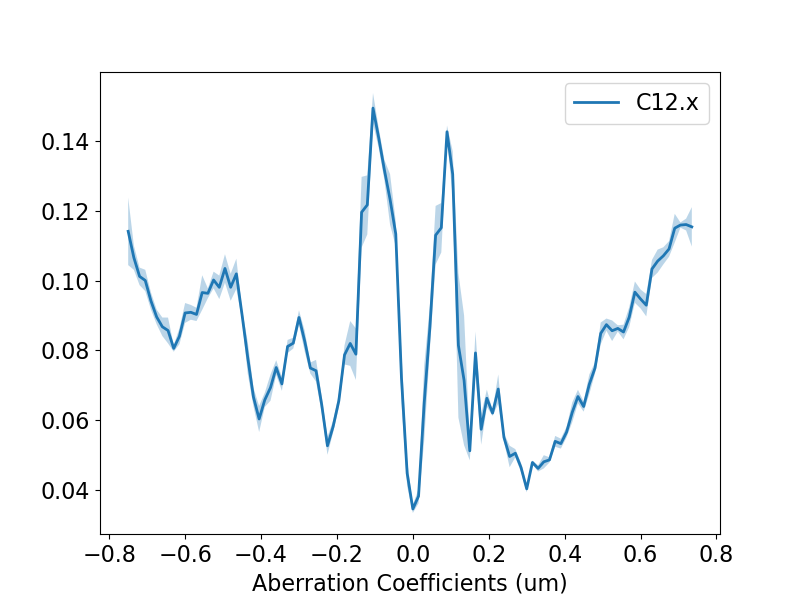

In [39]:
fig, ax = plt.subplots(1,1, figsize = [8,6])
y_list_avg = []
x_list_avg = np.array(x_list[::5])
std_list = np.zeros(nsteps)

for i in range(len(t_list)):
    temp = y_list[i].reshape([nsteps, 5])
    y_list_avg.append(temp.mean(-1))
    for j in range(nsteps):
        std_list[j] = np.std(temp[j,:])
    p = ax.plot(np.array(value_list) * 1e6, temp.mean(-1), linewidth = 2, label = coeff_list[i])
#     p = ax.plot(np.array(value_list) * 1e6, temp.mean(-1), linewidth = 2, label = t_list[i])
#         p = ax.plot(temp.mean(-1), linewidth = 2, label = coeff_list[i])
    ax.fill_between(np.array(value_list) * 1e6, temp.mean(-1) - np.array(std_list), 
                    temp.mean(-1) + np.array(std_list), alpha = 0.3)

ax.set_xlabel('Aberration Coefficients (um)',fontsize = 16)
# ax.set_ylabel('Normalized Defocus + Emit', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize = 16)

<IPython.core.display.Javascript object>


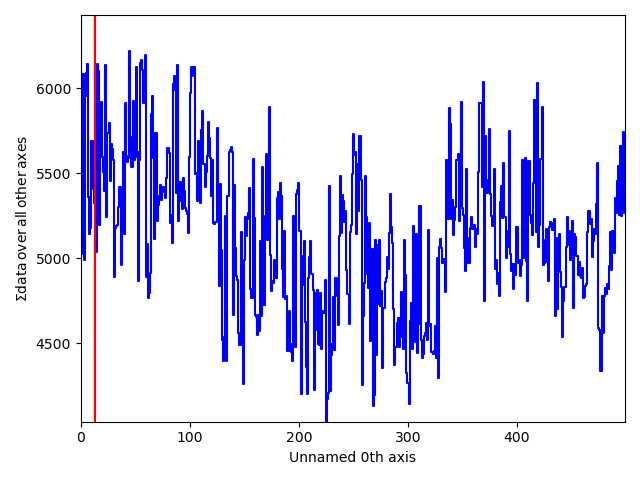

<IPython.core.display.Javascript object>


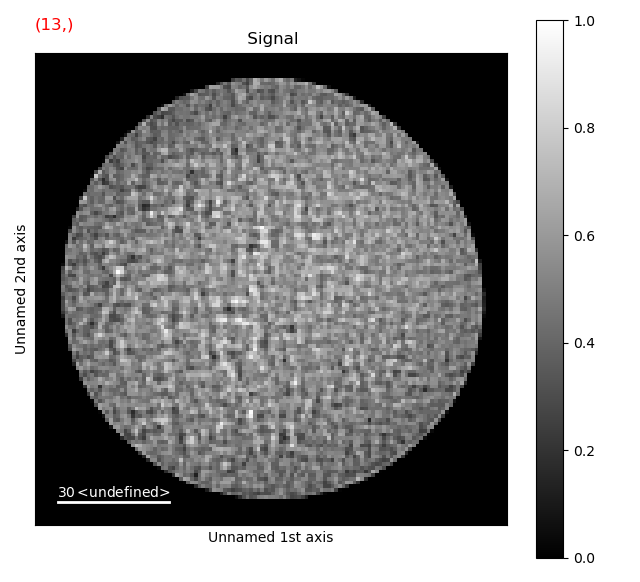

In [40]:
im = hs.signals.Signal2D(np.array(ronch_list))
im.plot()

## Optional: Crop the linescans to exclude the part outside the working region

In [155]:
abr_list = ["C10", "C12.x", "C12.y", "C21.x", "C21.y", "C23.x", "C23.y", "C30", 
"C32.x", "C32.y", "C34.x", "C34.y"]

abr_lim_cropped = [5e-7, 5e-7, 5e-7, 2e-5, 2e-5, 3e-6, 3e-6, 1.5e-4, 1.5e-4, 1.5e-4, 4e-5, 4e-5]

# assuming the new default is zero, x_default is a seris of 0.5
x_default = [0.5 for i in range(len(abr_list))]

C12.x 1 33


<IPython.core.display.Javascript object>


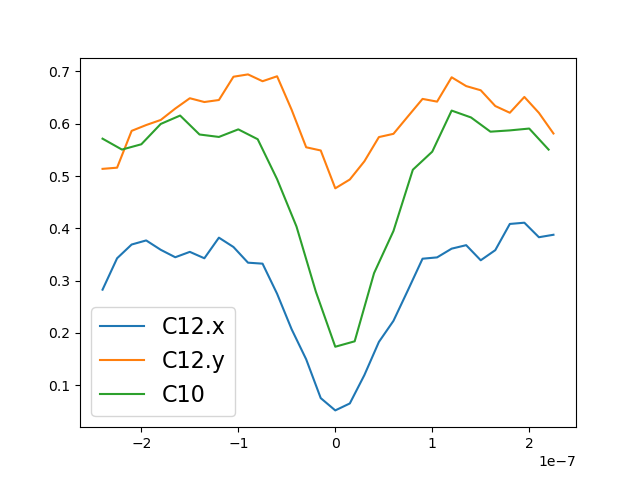

C12.y 2 33
C10 0 25


In [19]:
x_list_avg_cropped = []
y_list_avg_cropped = []

for i in range(len(coeff_list)):
    abr_coeff = coeff_list[i]
    idx = abr_list.index(abr_coeff)
    y_list = y_list_avg[i]
    
    # locate the minimum point and use that as the new zero point
    min_idx = np.argmax(y_list[40:60]) + 40
    
    # get the value list with zero point corrected
    abr_range = abr_lim[idx]
    abr_range_cropped = abr_lim_cropped[idx]
    value_list = [(i - min_idx) * abr_range / nsteps for i in range(nsteps)]
    cropped_idx = [i for i in range(nsteps) if abs(value_list[i]) < abr_lim_cropped[idx] / 2]
    
    print(abr_coeff, idx, len(cropped_idx))
    
    # create normalized x according to new range for each index in the cropped_idx
    for j in cropped_idx:
        x = [x_default[j] for j in range(len(x_default))]
        x[idx] = (value_list[j] + abr_range_cropped / 2) / abr_range_cropped
        y = y_list[j]
        x_list_avg_cropped.append(x)
        y_list_avg_cropped.append(1 - y)
    
    # make plot, to confirm that all the linescans are well aligned.
    plt.plot(value_list[cropped_idx[0]:cropped_idx[-1]], 1-y_list_avg[i][cropped_idx[0]:cropped_idx[-1]], label = abr_coeff)
    
plt.legend(fontsize = 16)

## Prepare the data for hyperparameter training

In [17]:
# y_list = np.ndarray.flatten(np.asarray(y_list_avg))
y_list = np.ndarray.flatten(np.asarray(y_list_avg))
print(y_list.shape)

(300,)


In [45]:
x_list[100:200]

array([[0.501     , 0.50133333, 0.        , 0.50066667, 0.50066667,
        0.502     , 0.502     ],
       [0.501     , 0.50133333, 0.01      , 0.50066667, 0.50066667,
        0.502     , 0.502     ],
       [0.501     , 0.50133333, 0.02      , 0.50066667, 0.50066667,
        0.502     , 0.502     ],
       [0.501     , 0.50133333, 0.03      , 0.50066667, 0.50066667,
        0.502     , 0.502     ],
       [0.501     , 0.50133333, 0.04      , 0.50066667, 0.50066667,
        0.502     , 0.502     ],
       [0.501     , 0.50133333, 0.05      , 0.50066667, 0.50066667,
        0.502     , 0.502     ],
       [0.501     , 0.50133333, 0.06      , 0.50066667, 0.50066667,
        0.502     , 0.502     ],
       [0.501     , 0.50133333, 0.07      , 0.50066667, 0.50066667,
        0.502     , 0.502     ],
       [0.501     , 0.50133333, 0.08      , 0.50066667, 0.50066667,
        0.502     , 0.502     ],
       [0.501     , 0.50133333, 0.09      , 0.50066667, 0.50066667,
        0.502     , 0.5

In [18]:
# x_list = np.asarray(x_list_avg)
x_list = np.asarray(x_list_avg)
x_list = x_list[:,0:7]
print(x_list.shape)

(300, 7)


In [84]:
np.save('NionRelated/X_linescan_45mrad_2ndOrder_100steps_250ms_bin1_rep5.npy', x_list)
np.save('NionRelated/Y_linescan_45mrad_2ndOrder_100steps_250ms_bin1_rep5.npy', y_list)

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [20]:
# x_list = np.load('NionRelated/X_usim_linescan_100steps_50ms_bin1_rep5.npy')
# y_list = np.load('NionRelated/Y_usim_linescan_100steps_50ms_bin1_rep5.npy')

# combine the data from linescans and the data from a test GP run

X = pd.DataFrame(x_list)
Y = pd.DataFrame(y_list).squeeze()

print('Y.shape',Y.shape,'\nX.shape',X.shape)

Y.shape (300,) 
X.shape (300, 7)


In [21]:
from hyperpar_trainer.tfgp_trainer import tfgp_trainer
tf.compat.v1.disable_eager_execution()

In [22]:
Niter = 1500

t0 = time.time()
tfgp = tfgp_trainer(X, Y,verbose=0)

tfgp.train(lr=0.005, 
           niter=Niter,
           optimizer=[tf.compat.v1.train.AdamOptimizer, tf.optimizers.SGD, tf.optimizers.RMSprop][0],
           gradient_clipping=0,
           kernel=['rbf','matern32','matern52'][0],
           correlations = False,
           offset = False,
           monitor_period=None,
           monitor_gradient=None) 

tfgp_t = time.time()-t0
print ('took ',tfgp_t ,' seconds')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
100% (1500 of 1500) |####################| Elapsed Time: 0:00:18 Time:  0:00:18


took  18.846431970596313  seconds


<IPython.core.display.Javascript object>


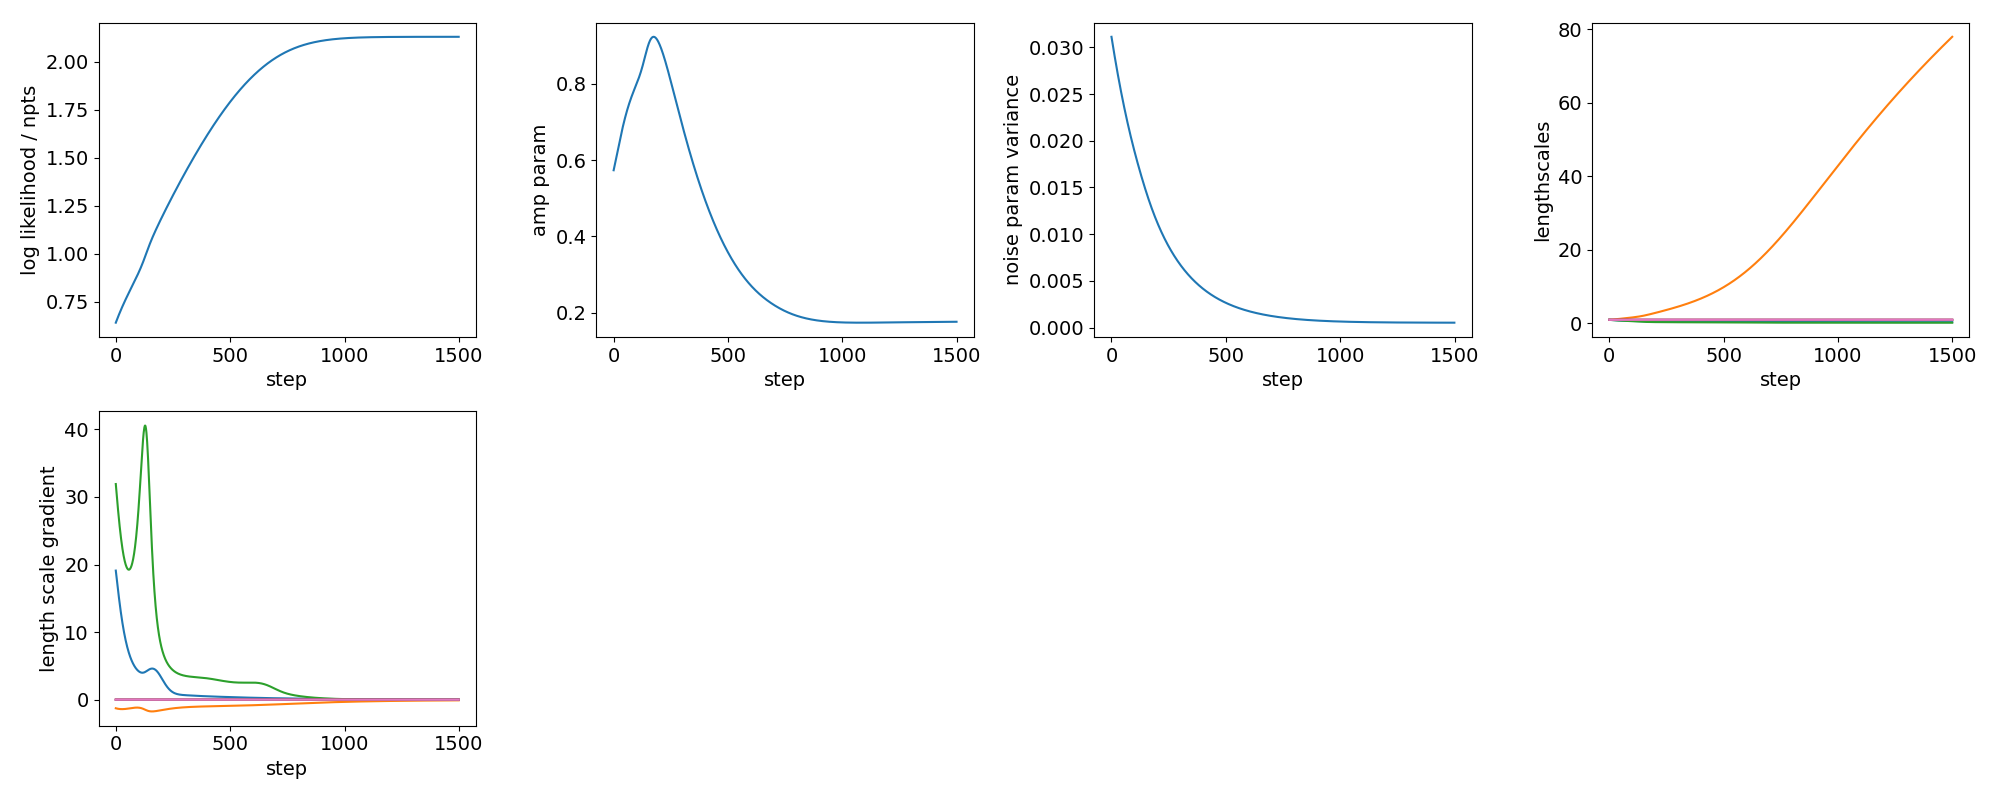

logLiklihod 638.8324870635679 
 amp 0.17598936831821202 
 noise 0.0005357642664001141 
 ls [ 0.36778705 77.94284674  0.22164103  1.0000818   1.0000818   1.00000537
  1.00000537]


In [23]:
from hyperpar_trainer.utils import GP_plot_results
tfgp_results = GP_plot_results(tfgp,Y)

In [24]:
from hyperpar_trainer.sk_trainer import sk_trainer
sk=sk_trainer()
sk.sk_train(X, Y, kernels=['rbf'], offset=False, verboseQ=True, saveQ=False)

********* 
 rbf
took  3.705970287322998  seconds
Inital kernel: 3.16**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=0.01)
Learned kernel: 0.317**2 * RBF(length_scale=[0.184, 0.283, 0.21, 1, 1, 1, 1]) + WhiteKernel(noise_level=0.00048)
Log-marginal-likelihood: 655.718


In [25]:
from hyperpar_trainer.gpy_trainer import gpy_trainer
gpy=gpy_trainer()
gpy.gpy_train(X, Y[:,None], kernels= ['rbf'], max_iters=5000, offset=False, verboseQ=True, saveQ=False)

********* 
 rbf
Optimization restart 1/5, f = -661.374727269498
Optimization restart 2/5, f = -655.7178834165575
Optimization restart 3/5, f = -655.7178834160503
Optimization restart 4/5, f = -655.7178834153785
Optimization restart 5/5, f = -655.7178834099298
took  3.5780160427093506  seconds
Log-marginal-likelihood: 661.375


In [26]:
# collect the results into a pandas dataframe to display
pd.DataFrame({"Param": ['time','negative log likelihood', 'amplitude', 'noise', 'offset'],
              "tfgp": [tfgp_t, tfgp_results['ll'], tfgp_results['amp_param'], tfgp_results['noise_param_variance'] , tfgp_results['offset_param']],
              "SK": [sk.sk_t, sk.results['ll'], sk.results['amp_param'], sk.results['noise_param_variance'] , sk.results['offset_param']],
              "GPy": [gpy.gpy_t, gpy.results['ll'], gpy.results['amp_param'], gpy.results['noise_param_variance'] , gpy.results['offset_param']],
             })


,Param,tfgp,SK,GPy
0,time,18.846432,3.705970,3.578016
1,negative log likelihood,-638.832487,655.717883,661.374727
2,amplitude,0.175989,0.100697,0.085764
3,noise,0.000536,0.000480,0.000191
4,offset,NaN,NaN,NaN


In [27]:
print('Lengthscales Comparison')
pd.DataFrame({"": X.keys(),
#               "Param":['HP','HP diff','S6','S7','OBJ','S3','S4'],
              "tfgp": tfgp_results['length_scale_param'],
              "SK": sk.results['length_scale_param'] ,
              "GPy": gpy.results['length_scale_param']
             })

Lengthscales Comparison


,,tfgp,SK,GPy
0,0,0.367787,0.184481,0.175202
1,1,77.942847,0.282806,0.301698
2,2,0.221641,0.209726,0.075377
3,3,1.000082,1.000000,1.000000
4,4,1.000082,1.000000,1.000000
5,5,1.000005,1.000000,1.000000
6,6,1.000005,1.000000,1.000000
